In [2]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np
from scipy import  sparse

import torch
import torch.nn.functional as F
import torch.nn as nn

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.genotypevae.genotypeVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import SCVIZ_CheckNet2Net

import pickle5
from tqdm import tqdm 
from sklearn.neighbors import NearestNeighbors
from perturbnet.baselines.knn import *
from perturbnet.baselines.linear import solve_y_axb


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data and PerturbNet

In [60]:

some_path = ""
path_cinn_model = some_path + '/cinn/50ep_7removed/'
path_data = ''
path_genovae_model = some_path + "/genotypevae/trained_models/model_params.pt"


path_scvi_model_train = some_path + "/cellvae/700ep/model/"
adata = ad.read_h5ad(os.path.join(path_data, "Norman_count.h5ad"))
control_expr = adata[adata.obs.perturb_string == "ctrl"].layers["counts"].A.mean(axis = 0)
adata_save_index = np.array(adata.obs[adata.obs["if_remove"] != "remove"].index).astype(int)
adata = adata[adata_save_index, :].copy()    
print(adata.obs.shape)
adata.obs = adata.obs.reset_index()
    
scvi.data.setup_anndata(adata, layer = "counts")
adata_test_index = np.array(adata.obs[adata.obs["1st_ge_selected_holdout"] == "test"].index).astype(int)
adata_test = adata[adata_test_index, :].copy()
    
adata_train_index = np.array(adata.obs[adata.obs["1st_ge_selected_holdout"] == "train"].index).astype(int)
adata_train = adata[adata_train_index, :].copy()
    

perturb_with_onehot_kept, perturb_with_onehot_removed = np.array(adata_train.obs["perturb_string"]), np.array(adata_test.obs["perturb_string"])
trt_obs_list, trt_unseen_list = np.unique(perturb_with_onehot_kept), np.unique(perturb_with_onehot_removed)    

onehot_unseen_idx = []
for i in range(len(trt_unseen_list)):
    trt = trt_unseen_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_smile"] == trt)[0][0]
    onehot_unseen_idx.append(onehot_idx)
unseen_onehot = adata.uns["ordered_all_onehot"][onehot_unseen_idx]

onehot_seen_idx = []
for i in range(len(trt_obs_list)):
    trt = trt_obs_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_smile"] == trt)[0][0]
    onehot_seen_idx.append(onehot_idx)
seen_onehot = adata.uns["ordered_all_onehot"][onehot_seen_idx] 
    
    



    


(94676, 11)
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 94676 cells, 2279 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [61]:
scvi_model_cinn = scvi.model.SCVI.load(path_scvi_model_train, adata_train, use_cuda = False)
scvi_model_de = scvi_predictive_z(scvi_model_cinn)


device = "cuda" if torch.cuda.is_available() else "cpu"

model_genovae = GenotypeVAE().to(device)
model_genovae.load_state_dict(torch.load(path_genovae_model, map_location = device))
model_genovae.eval()




perturbToOnehot = {}
for i in range(trt_unseen_list.shape[0]):
    perturbToOnehot[trt_unseen_list[i]] = i
        

torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim=10,
                                         embedding_dim=10,
                                         conditioning_depth=2,
                                         n_flows=20,
                                         in_channels=10,
                                         hidden_dim=1024,
                                         hidden_depth=2,
                                         activation="none",
                                         conditioner_use_bn=True)

model_c = Net2NetFlow_scVIGenoFlow(configured_flow=flow_model,
                                   cond_stage_data=perturb_with_onehot_kept,
                                   model_con=model_genovae,
                                   scvi_model = scvi_model_cinn,
                                   perturbToOnehotLib = perturbToOnehot,
                                  oneHotData = seen_onehot)


model_c.to(device=device)

model_c.load(path_cinn_model)
model_c.eval()

model_g = model_c.model_con
model_g.eval()

perturbnet_model = SCVIZ_CheckNet2Net(model_c, device, scvi_model_de)
    
    

if sparse.issparse(adata_test.X):
    usedata = adata_test.X.A
else:
    usedata = adata_test.X

if sparse.issparse(adata_test.layers["counts"]):
    usedata_count = adata_test.layers["counts"].A
else:
    usedata_count = adata_test.layers["counts"]

fidscore_cal = fidscore()




INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']                           
INFO     Successfully registered anndata object containing 56743 cells, 2279 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
Note: Conditioning network uses batch-normalization. Make sure to train with a sufficiently large batch size


In [62]:
normModel = NormalizedRevisionRSquare(largeCountData = usedata_count)
Lsample_obs = scvi_model_cinn.get_latent_library_size(adata = adata_train, give_mean = False)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []

np.random.seed(2023)
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

for indice_trt in tqdm(range(len(trt_unseen_list))):
    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type

        
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type  =  np.random.choice(idx_trt_type, 1000, replace = False)

    Lsample_idx = np.random.choice(range(Lsample_obs.shape[0]), len(idx_trt_type), replace=True)
        
    DEG_gene = adata.uns["rank_genes_groups_t_test"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (len(idx_trt_type), 1))
    _, _, _, embdata_torch = model_g(torch.tensor(onehot_indice_trt).float().to(device))


    trt_onehot = embdata_torch.cpu().detach().numpy()
    library_trt_latent =Lsample_obs[Lsample_idx]



    real_data = usedata_count[idx_trt_type]

    _, fake_data = perturbnet_model.sample_data(trt_onehot, library_trt_latent)


    r2_value, real_norm, rfake_norm = normModel.calculate_r_square(real_data, fake_data)
    pear_value = normModel.calculate_pearson(real_data, fake_data)

        

    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value,_,_ = normModel.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = normModel.calculate_pearson(real_data_deg, fake_data_deg)

   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1)
    
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]

        r2_large_value,_ ,_  = normModel.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = normModel.calculate_pearson(real_data_large, fake_data_large)
        

    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

results_PerturbNet = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


100%|██████████| 95/95 [00:25<00:00,  3.78it/s]


# Biolord

In [123]:
biolord_path = some_path + "pred_mean.pkl"
with open(biolord_path, "rb")as fh:
        biolord = pickle.load(fh)
fidscore_cal = fidscore()
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []

for pert, pred  in tqdm(biolord.items()):
    
    
    fake_data = np.expand_dims(pred[-1],0)
    real_data_idx = adata.obs[adata.obs["perturb_string"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    real_data = adata[real_data_idx, :].copy().X
    fake_data = np.repeat(fake_data, 10,0)
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

    DEG_gene = adata.uns["rank_genes_groups_t_test"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value  = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)

   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1)
    
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]

        r2_large_value  = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = fidscore_cal.calculate_pearson(real_data_large, fake_data_large)
        

    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

results_biolord = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })

  0%|          | 0/94 [00:00<?, ?it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  3%|▎         | 3/94 [00:00<00:03, 25.44it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  6%|▋         | 6/94 [00:00<00:03, 25.09it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/annd

/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 61%|██████    | 57/94 [00:02<00:01, 25.17it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 64%|██████▍   | 60/94 [00:02<00:01, 25.16it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarn

# GEARS

In [135]:
with open(some_path + '/gears_output/unseen_holdout_ge1.pkl', "rb") as fh:
    gears = pickle5.load(fh)
    
my_string_name = adata_test.obs["perturb_string"].unique()

old_keys = list(gears.keys())

for i in range(len(old_keys)):
    item = old_keys[i]
    tmp =  item.split("+")
    new = tmp[0] + "/" + tmp[1]
    gears[new] = gears.pop(item)


    
for i in gears.keys():
    if i in my_string_name:
        continue
    else:
        tmp = i.split("/")
        new = tmp[1] + "/" + tmp[0]
        gears[new] = gears.pop(i)
fidscore_cal = fidscore()
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []

for pert, pred  in tqdm(gears.items()):
    
    
    real_data_idx = adata.obs[adata.obs["perturb_string"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    real_data = adata[real_data_idx, :].copy().X
    fake_data = pred
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

    DEG_gene = adata.uns["rank_genes_groups_t_test"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value  = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)

   
    large_effect_idx =   DEG_idx[abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1)
    
    if num_large <=1:
        hd_large_value = 1.5
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]

        r2_large_value  = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = fidscore_cal.calculate_pearson(real_data_large, fake_data_large)
        

    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)

results_gears = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })

  0%|          | 0/94 [00:00<?, ?it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  3%|▎         | 3/94 [00:00<00:03, 23.10it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  6%|▋         | 6/94 [00:00<00:03, 24.10it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/annd

/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 61%|██████    | 57/94 [00:02<00:01, 22.75it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 64%|██████▍   | 60/94 [00:02<00:01, 23.57it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarn

# Linear

In [64]:

trt_unseen_num_gene = []
for i in trt_unseen_list:
    trt_unseen_num_gene.append(adata.obs[adata.obs["perturb_string"] == i]["num_gene_perturbed"].iloc[0])
    
perturbed_genes = []
train_expr_mean_dict = {}
skip_pert_train = []
for i in adata_train.obs["perturb_string"].unique():
    if adata_train[adata_train.obs.perturb_string == i].obs["num_gene_perturbed"][0] == 1:
        ge1 = i.split("/")[0]
        ge2 = i.split("/")[1]
        if (ge1 not in adata_train.var_names) and (ge2 not in adata_train.var_names):
            skip_pert_train.append(i)
            continue
        perturbed_genes.append(ge1)
        perturbed_genes.append(ge2)
   
        train_expr_mean_dict[i] = adata[adata.obs.perturb_string == i].layers["counts"].A.mean(axis = 0)
perturbed_genes = np.unique(perturbed_genes)
Y_train = pd.DataFrame(train_expr_mean_dict )
Y_train.index = adata_train.var_names
    
pca = PCA(n_components=10)
G = pca.fit_transform(Y_train)



G_df = pd.DataFrame(G, index=adata_train.var_names)  # Use gene names from AnnData var_names


perturbed_genes = list(set(perturbed_genes) & set(G_df.index))
G_subset = G_df.loc[perturbed_genes]  # Subset of G corresponding to perturbed genes

P = G_subset.T 

coefs  = solve_y_axb(Y = Y_train.to_numpy(), A = G, B = P.to_numpy())

**predict all the unseen genes as single gene perturbations in the test set**

In [65]:
perturbed_genes_test = []
skip_pert_test = []
trt_unseen_single = []
for i in trt_unseen_list:
    if adata_test[adata_test.obs.perturb_string == i].obs["num_gene_perturbed"][0] == 1:
        ge1 = i.split("/ctrl")[0]
        if (ge1 not in adata_test.var_names):
            skip_pert_test.append(i)
            continue
        else:
            perturbed_genes_test.append(ge1)
    else: 
        ge1 = i.split("/")[0]
        ge2 = i.split("/")[1]
        if (ge1 not in adata_test.var_names) or (ge2 not in adata_test.var_names):
            skip_pert_test.append(i)
            continue
        else:
            perturbed_genes_test.append(ge1)
            perturbed_genes_test.append(ge2)
        
perturbed_genes_test = np.unique(perturbed_genes_test)

P_test =(G_df.loc[perturbed_genes_test]).T  


pred = G @ coefs['K'] @ P_test + coefs['center'] 

In [68]:
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []


for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]
    if pert in skip_pert_test:
        continue
    pert_type = trt_unseen_num_gene[indice_trt]
    #fake_data = pred
    real_data_idx = adata.obs[adata.obs["perturb_string"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    
    if pert_type == 1:
        fake_data = pred[pert.split("/ctrl")[0]]
        
    elif pert_type == 2:
        
        fake_data = pred[pert.split("/")[0]] +  pred[pert.split("/")[1]] - control_expr
    else:
        continue
    r2_value = r2_score(np.average(real_data, axis = 0),fake_data)
    _, _ ,pear_value ,_ ,_ = stats.linregress(np.average(real_data, axis = 0), fake_data)


    
    DEG_gene = adata.uns["rank_genes_groups_t_test"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[DEG_idx]
    r2_deg_value = r2_score(np.average(real_data_deg, axis = 0), fake_data_deg)
    _, _ ,pear_deg_value ,_ ,_ = stats.linregress(np.average(real_data_deg, axis = 0), fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[large_effect_idx ]

        r2_large_value  = r2_score(np.average(real_data_large, axis = 0),fake_data_large)
        _, _ ,pear_large_value,_ ,_ = stats.linregress(np.average(real_data_large, axis = 0), fake_data_large)


    
    
    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_linear = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })

  0%|          | 0/95 [00:00<?, ?it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  3%|▎         | 3/95 [00:00<00:03, 23.39it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  6%|▋         | 6/95 [00:00<00:03, 23.23it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/annd

/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 61%|██████    | 58/95 [00:02<00:01, 23.94it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 64%|██████▍   | 61/95 [00:02<00:01, 24.34it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarn

# Training Sample

In [71]:
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []

np.random.seed(2023)
for indice_trt in range(len(trt_unseen_list)):
    pert = trt_unseen_list[indice_trt]
    seen_data = adata_train.layers["counts"].A
    seen_data_idx = list(range(seen_data.shape[0]))
    #fake_data = pred
    real_data_idx = adata.obs[adata.obs["perturb_string"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    norm_vec_real = adata[real_data_idx, :].obs["n_counts_total"].to_numpy()
    idx_rsample = np.random.choice(seen_data_idx, len(real_data_idx), replace=True)
    fake_data = seen_data[idx_rsample]
    norm_vec_fake = adata_train.obs["n_counts_total"].to_numpy()[idx_rsample]
    
    r2_value = normModel.calculate_r_square_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)
    pear_value = normModel.calculate_pearson_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)


    
    DEG_gene = adata.uns["rank_genes_groups_t_test"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value= normModel.calculate_r_square_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    pear_deg_value = normModel.calculate_pearson_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = normModel.calculate_r_square_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        pear_large_value = normModel.calculate_pearson_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
    
    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_sample = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                       })


/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/

/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/

# KNN

In [ ]:
_, _, _, embdata_torch_seen = model_genovae(torch.tensor(seen_onehot).float().to(device))
embdata_numpy_seen = embdata_torch_seen.cpu().detach().numpy()
_, _, _, embdata_torch_unseen = model_genovae(torch.tensor(unseen_onehot).float().to(device))
embdata_numpy_unseen = embdata_torch_unseen.cpu().detach().numpy()
neigh = NearestNeighbors(n_neighbors=5)
neigh_fit = neigh.fit(embdata_numpy_seen)
fidscore_cal = fidscore()

normModel = NormalizedRevisionRSquare(largeCountData = usedata_count)

adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)

perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []

pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
seen_data = adata_train.layers["counts"].A
seen_data_idx = list(range(seen_data.shape[0]))

for indice_trt in tqdm(range(len(trt_unseen_list))):
    pert = trt_unseen_list[indice_trt]

    real_data_idx = adata.obs[adata.obs["perturb_string"] == pert].index
    if real_data_idx.shape[0] > 1000:
        real_data_idx = np.random.choice(real_data_idx, 1000, replace = False)
    
    real_data = adata[real_data_idx, :].copy().layers["counts"].A
    norm_vec_real = adata[real_data_idx, :].obs["n_counts_total"].to_numpy()
    distances, other_trts = neigh_fit.kneighbors(embdata_numpy_unseen[[indice_trt]], 5, return_distance=True)
    samplerNN = samplefromNeighbors(distances, other_trts)
    idx_sample = samplerNN.samplingTrt(trt_obs_list, perturb_with_onehot_kept, len(real_data_idx))
    
    fake_data = seen_data[idx_sample]
    norm_vec_fake = adata_train.obs["n_counts_total"].to_numpy()[idx_sample]
    
    r2_value = normModel.calculate_r_square_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)
    pear_value = normModel.calculate_pearson_norm_by_all(real_data, fake_data,norm_vec_real,norm_vec_fake)

    
    DEG_gene = adata.uns["rank_genes_groups_t_test"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]
    r2_deg_value= normModel.calculate_r_square_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    pear_deg_value = normModel.calculate_pearson_norm_by_all(real_data_deg, fake_data_deg,norm_vec_real,norm_vec_fake)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1]
    num_large =  sum(abs(adata.uns["rank_genes_groups_t_test"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        r2_large_value = 1.5
        pear_large_value = 1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = normModel.calculate_r_square_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
        pear_large_value = normModel.calculate_pearson_norm_by_all(real_data_large, fake_data_large,norm_vec_real,norm_vec_fake)
    
    
    
    perturb.append(pert)
    ncell.append(real_data_idx.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_KNN = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,"pear":pear,"r2_deg":r2_deg, "pear_deg":pear_deg,
                        "r2_large":r2_large, "pear_large": pear_large
                            })


  0%|          | 0/95 [00:00<?, ?it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  3%|▎         | 3/95 [00:00<00:10,  8.88it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  5%|▌         | 5/95 [00:00<00:09,  9.58it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  7%|▋         | 7/95 [00:00<00:10,  8.39it/s]/home/wzqian/.local/

 57%|█████▋    | 54/95 [00:05<00:04,  8.85it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 59%|█████▉    | 56/95 [00:05<00:04,  9.75it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 61%|██████    | 58/95 [00:05<00:03,  9.70it/s]/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
 63%|██████▎   | 60/95 [00:06<00:03, 10.69it/s]/home/wz

# Fiter out perturbation with any seen genes

In [100]:
df_meta = adata.obs[adata.obs["1st_ge_selected_holdout"]=="train"]
df_meta = df_meta[df_meta["if_remove"]!="remove"]
seen_pert = df_meta["perturb_string"].unique()
seen_ge = []
for i in seen_pert:
    ge1 = i.split('/')[0]
    ge2 = i.split('/')[1]
    seen_ge.append(ge1)
    seen_ge.append(ge2)
seen_ge  = list(set(seen_ge))
seen_ge_type_tmp = []
for i in range(len(trt_unseen_list)):
    pert = trt_unseen_list[i]
    ge1 = pert.split('/')[0]
    ge2 = pert.split('/')[1]
    if "ctrl" in pert:
        if ge1 in seen_ge and ge2 in seen_ge:
            seen_ge_type = "1/1"
        else:
            seen_ge_type = "0/1"
    else:
        if (ge1 in seen_ge) + (ge2 in seen_ge) == 0:
            seen_ge_type = "0/2"
        elif (ge1 in seen_ge) + (ge2 in seen_ge) == 1:
            seen_ge_type = "1/2"
        else:
            seen_ge_type = "2/2"
    seen_ge_type_tmp.append(seen_ge_type)

In [104]:
save_pert = trt_unseen_list[np.array(seen_ge_type_tmp) != "1/2"]

In [105]:
save_pert

array(['AHR/KLF1', 'AHR/ctrl', 'BAK1/KLF1', 'BAK1/TMSB4X', 'BAK1/ctrl',
       'C3ORF72/FOXL2', 'CBL/CNN1', 'CBL/ctrl', 'CDKN1A/CDKN1B',
       'CDKN1A/ctrl', 'CDKN1B/ctrl', 'CEBPA/CEBPB', 'CEBPA/KLF1',
       'CEBPA/ctrl', 'CEBPB/FOSB', 'CEBPB/LYL1', 'CEBPB/MAPK1',
       'CEBPB/OSR2', 'CEBPB/ctrl', 'CLDN6/KLF1', 'CLDN6/ctrl',
       'CNN1/MAPK1', 'CNN1/ctrl', 'FOSB/IKZF3', 'FOSB/OSR2', 'FOSB/ctrl',
       'FOXF1/FOXL2', 'FOXF1/HOXB9', 'FOXF1/ctrl', 'FOXL2/HOXB9',
       'FOXL2/ctrl', 'HOXB9/ctrl', 'IER5L/LYL1', 'IKZF3/MAPK1',
       'IKZF3/ctrl', 'KLF1/ctrl', 'LYL1/ctrl', 'MAPK1/ctrl', 'OSR2/ctrl',
       'SGK1/TBX2', 'SGK1/TBX3', 'SGK1/ctrl', 'TBX2/TBX3', 'TBX2/ctrl',
       'TBX3/ctrl', 'TMSB4X/ctrl'], dtype=object)

In [136]:
results_PerturbNet_sub = results_PerturbNet[results_PerturbNet["perturbation"].isin(save_pert)]
results_biolord_sub = results_biolord[results_biolord["perturbation"].isin(save_pert)]
results_linear_sub = results_linear[results_linear["perturbation"].isin(save_pert)]
results_sample_sub = results_sample[results_sample["perturbation"].isin(save_pert)]
results_KNN_sub = results_KNN[results_KNN["perturbation"].isin(save_pert)]
results_gears_sub = results_gears[results_gears["perturbation"].isin(save_pert)]

../perturbnet/util.py:963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


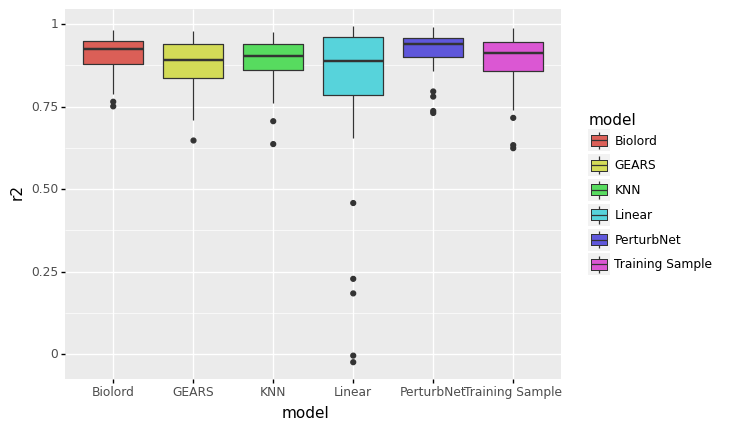

<ggplot: (1412335399685)>

In [137]:
boxplot_metrics({"PerturbNet":results_PerturbNet_sub, "Biolord":results_biolord_sub, 
                 "GEARS":results_gears_sub,"Linear": results_linear_sub,
                 "Training Sample":results_sample_sub,
                "KNN": results_KNN_sub }, metric_key = "r2")

../perturbnet/util.py:963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


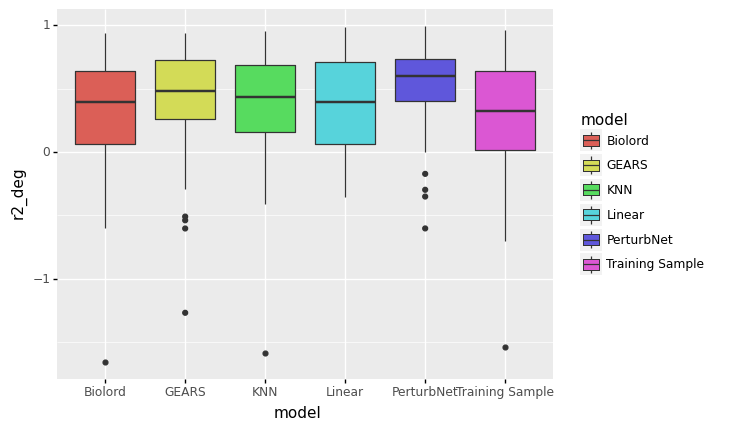

<ggplot: (1412303020993)>

In [138]:
boxplot_metrics({"PerturbNet":results_PerturbNet_sub, "Biolord":results_biolord_sub, 
                 "GEARS":results_gears_sub,"Linear": results_linear_sub,
                 "Training Sample":results_sample_sub,
                "KNN": results_KNN_sub }, metric_key = "r2_deg")